#### Imports

In [1]:
# activates python modules auto reload
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import shap
import pandas as pd
from math import sqrt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from src.features import preprocess
from src.models import build_model

#### Read Data

In [2]:
df = pd.read_csv('../data/house_sales.csv', nrows=None)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(3)

(18445, 16)


,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.511234,-122.256775,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.721023,-122.318862,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.737927,-122.233196,2720,8062


## Price Prediction

### Build model

Lets define the features to be used in the prediction model, separating them between numeric and categorical.

In [3]:
num_feat = [
    'num_bed',
    'num_bath',
    'size_house',
    'size_lot',
    'num_floors',
    'condition',
    'size_basement',
    'year_built',
    'renovation_date',
    'latitude',
    'longitude',
    'avg_size_neighbor_houses',
    'avg_size_neighbor_lot',
    'is_waterfront'
]

cat_feat = [
    'zip'
]

The features that are not making into the model and thus will have no effect on the outcome are:

In [4]:
print(*(set(df.columns.tolist()) - set(cat_feat) - set(num_feat)))

price


#### Preprocess Data

In [5]:
df = preprocess(df, num_feat, cat_feat, 'price')
print(df.shape)
df.head(3)

(18445, 85)


,num_bed,num_bath,size_house,size_lot,num_floors,condition,size_basement,year_built,renovation_date,latitude,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,price
0,-0.398985,-1.448538,-0.980964,-0.224493,-0.914436,-0.630878,-0.661827,-0.544939,-0.210967,-0.352129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,221900
1,-0.398985,0.169771,0.527510,-0.186423,0.934687,-0.630878,0.239844,-0.681179,4.727632,1.161900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,538000
2,-1.469736,-1.448538,-1.425909,-0.120468,-0.914436,-0.630878,-0.661827,-1.294259,-0.210967,1.283894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000


#### Split Training and Test sets

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=8)

print('Train:\t%d houses' % df_train.shape[0])
print('Test:\t%d houses' % df_test.shape[0])

Train:	14756 houses
Test:	3689 houses


#### Classifier
The classifier will be a random forest.

In [7]:
clf = RandomForestRegressor(n_jobs=5)

##### Fit

In [8]:
clf.fit(df_train.drop(columns='price'), df_train['price']);

### Make prediction

In [9]:
y_test = df_test['price']
y_pred = clf.predict(df_test.drop(columns='price'))

### Measure Quality

In [10]:
r2 = metrics.r2_score(y_test, y_pred)
mse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Model Metrics:')
print('R^2: %.2f' % r2)
print('Sqrt Mean Squared Error: %.2f' % mse)

Model Metrics:
R^2: 0.86
Sqrt Mean Squared Error: 134365.61


#### R squared
The random forest regressor obtained R squared equal to 0.86, this is quite good and indicates that our model is doing a good job at predicting prices.

#### SqRoot of the Mean Squared Error
$134365.61 is a reasonable value for root of the mean squared error.

This value could be improved by tweakingusing more sophisticated models.

### Model interpretation

Shap values:

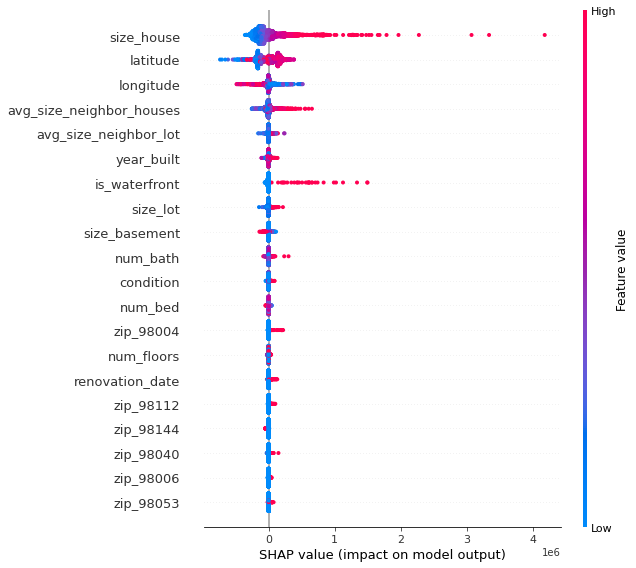

In [11]:
shap.initjs()
explainer = shap.TreeExplainer(clf, data=df_train)
shap_values = explainer.shap_values(df_test.drop(columns='price'), approximate=True)
shap.summary_plot(shap_values, df_test.drop(columns='price'))

Random forest, being a non-linear classifier, was able to extract more value from latitude and longitude values. These features were, after house size, the most impactful.

Latitude and longitude here do not always impact the price in the same way. But overall, higher latitudes and lower longitudes (western) tend to have more expensive homes.

The size of nearby homes also plays a important role, larger nearby homes increase the property price tag, indicating that rich neiborhoods are desired by buyers. 

Being waterfront increases the price tag. There's a huge variation in the shap value of waterfront properties, this may indicate that some waterfront views are more valued than others.

As for the house's interior space, the number of bathrooms was the most related to the price tag. Possibly due to its inherit relation with the house size. 

The number of bedrooms, surprisingly, has little impact. 